In [1]:
import sys
[sys.path.append(i) for i in ['.', '..']]
import torch
import numpy as np
from mirtorch.alg import CG, FISTA, POGM, power_iter
from mirtorch.linear import LinearMap, FFTCn, NuSense, Sense, FFTCn, Identity, Diff2dframe, Gmri, Wavelet2D
from mirtorch.prox import Prox, L1Regularizer
import matplotlib.pyplot as plt
import copy
import h5py
import torchkbnufft as tkbn

%load_ext autoreload
%autoreload 2

In [2]:
ex_multi = np.load('AXT2_210_6001736_layer11.npz')
device0 = torch.device('cpu')
# k-space
k_c = torch.tensor(ex_multi['k_r'] + 1j*ex_multi['k_i']).to(device0)/32767.0
# Sense map
s_c = torch.tensor(ex_multi['s_r'] + 1j*ex_multi['s_i']).to(device0)/32767.0
# Define Sense operator
(nc, nh, nw) = s_c.shape
Fop = FFTCn((nc, nh, nw), (nc, nh, nw), (1,2), norm = 'ortho')
# Conjugate phase reconstruction
I1 = (Fop.H*k_c).to(torch.complex64).unsqueeze(0)
nx = 320
ny = 320
I1 = I1[:,:,nh//2-nx//2:nh//2+nx//2,nw//2-ny//2:nw//2+ny//2]
s_c = s_c[:,nh//2-nx//2:nh//2+nx//2,nw//2-ny//2:nw//2+ny//2].unsqueeze(0).to(torch.complex64)
mask = torch.zeros(nx,ny)
mask[:,0:ny:4]=1
mask[:,140:180]=1
# mask = torch.ones(nx,ny)

Fop = FFTCn((1, nc, nx, ny), (1, nc, nx, ny), (2,3), norm = 'ortho')
K1 = Fop*I1
K1.requires_grad = True
Sop = Sense(s_c, mask.unsqueeze(0))
I0 = Sop.H*K1
print('kspace shape', K1.shape)
print('image shape', I0.shape)

kspace shape torch.Size([1, 16, 320, 320])
image shape torch.Size([1, 1, 320, 320])


In [3]:
W = Wavelet2D(I0.shape, padding='periodization', J=2, wave_type = 'db4')

In [4]:
L = power_iter(Sop, I0, max_iter=200)

calculation of max singular value accomplished at 14 iterations
The spectural norm is 0.9999338984489441


In [5]:
def gradA(x):
    return Sop.H*Sop*x-I0

In [6]:
P = L1Regularizer(1e-5, T = W)

In [17]:
pg = POGM(f_grad=gradA, f_L=L[1].item(), g_prox=P, max_iter=40).run_alg(x0=I0)

In [8]:
fs = FISTA(f_grad=gradA, f_L=L[1].item(), g_prox=P, max_iter=100).run_alg(x0=I0)

Text(0.5, 1.0, 'FISTA Recon')

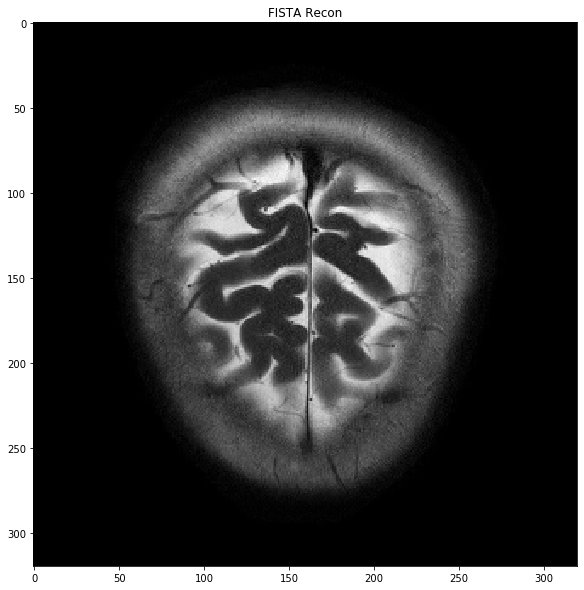

In [19]:
plt.figure(figsize=(20,10))
plt.imshow(((torch.abs((fs[0,0,:,:])))).cpu().data.numpy(),cmap='gray')
plt.title('FISTA Recon')

Text(0.5, 1.0, 'POGM recon')

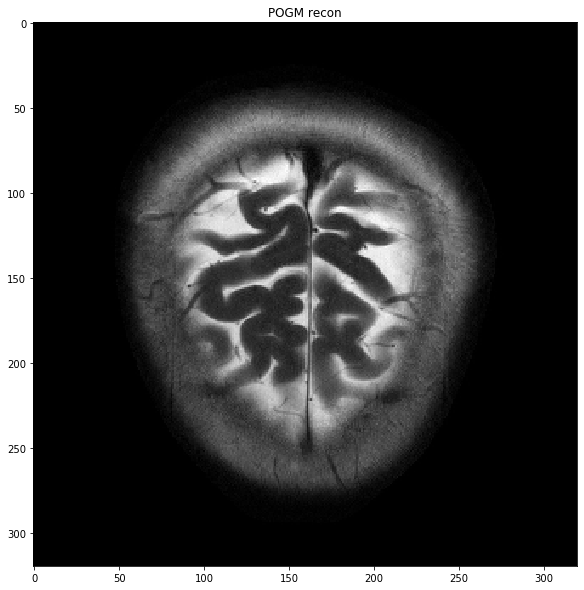

In [20]:
plt.figure(figsize=(20,10))
plt.imshow(torch.abs((pg[0,0,:,:])).cpu().data.numpy(),cmap='gray')
plt.title('POGM recon')